In [1]:
using Gadfly;
using Iterators;
using Distributions;
using DataStructures;
srand(100);

type SearchParams
    initial_population::Unsigned
    max_generations::Unsigned
    max_diffusion::Unsigned
    walk_prob::Real
end

p = SearchParams(3, #Población inicial
                 30, #Generaciones máximas
                 20, #Difusión máxima
                 0.5); #Probabílidad de cada camino

type SearchSpace
    dim::Unsigned
    lbound::Array{Real, 1}
    ubound::Array{Real, 1}
    f::Function
end

# Preliminares

## Espacio de búsqueda

$ f: [-500, 500] \times [-500, 500] \to \mathbb R$  
$ f(x_1, x_2) \mapsto -x_1 \sin{\sqrt{|x_1|}} -x_2 \sin{\sqrt{|x_2|}} $

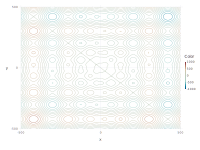

In [2]:
function objective_function(x::Array)
    sum(-1.*x .* sin.(sqrt.(abs.(x))))
end
dim = 2;
s = SearchSpace(dim, #Dimension of the search space
                ones(dim).*-500, #Lower bound of the search space
                ones(dim).*500, #Upper bound of the search space
                objective_function);

set_default_plot_size(20cm, 15cm)
plot(x=s.lbound[1]:10:s.ubound[1], y=s.lbound[2]:10:s.ubound[2], z=(x,y) -> s.f([x,y]), Geom.contour)

## Fractal search

Explora mediante fractales generados mediante el modelo DLA (Diffusion Limited Aggregation)

- Cada partícula tiene una energía inicial
- Alrededor de una particula se generan más aleatoriamente (difusión)
- La energía de las partículas se divide en la difusión
- A las mejores partículas se les entrega más energía

In [3]:
type Particle
    x::Array #Posición
    f::Real #Evaluación de f en x
    e::Real #Energía de la partícula
end

function Base.isless(p1::Particle, p2::Particle)
    p1.f < p2.f
end

function Base.copy(p::Particle)
    Particle(copy(p.x), p.f, p.e)
end

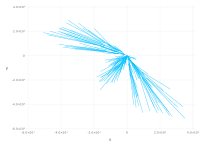

In [10]:
particles = [Particle([0.0, 0.0], 0, 100)]
pathx = [0.0]
pathy = [0.0]
startx = []
starty = []
endx = []
endy = []
b = [100, 100]
for i = 1:4
    for pind = 1:length(particles)
        par = particles[pind]
        if par.e > 1
            for j = 1:3
                x = par.x .+ rand.(Normal.(par.x, b)) - (rand(2) .* b - rand(2) .* par.x)
                push!(particles, Particle(x, 0, par.e/3))
                push!(startx, x[1])
                push!(endx, par.x[1])
                push!(starty, x[2])
                push!(endy, par.x[2])
                IJulia.clear_output(true)
                display(plot(x=startx, y=starty, xend=endx, yend=endy, Geom.segment))
                #sleep(0.1)
            end
        end
        par.e = par.e / 3
        particles[pind] = par
    end
end

# Stochastic Fractal Search

Problemas de Fractal Search:

- Tiene demasiados parámetros libres
- No hay intercambio de información entre partículas
- El número de partículas aumenta rápidamente, y con ello el tiempo de ejecución

## Estructura

Dos procesos principales:
 1. **Difusión** (Explotación)
 2. **Acuatlización** (Exploración)

### Difusión

Parecido a Fractal Search, cada partícula se difunde en su entorno.  
Solo se tiene en cuenta la mejor partícula de la difusión.

En el proceso de disfusión hay que comprobar los límites de búsqueda

In [5]:
function check_bounds(x, lbound, ubound)
    min.(max.(x, lbound), ubound)
end;

Se usan dos caminos aleatorios basados en la distribución normal:

$W_1 = N(BP, \sigma) + (\epsilon BP - \epsilon' P_i)$  
$W_2 = N(P_i, \sigma)$

Donde:
- $BP$ es la posición del mejor punto del grupo
- $P_i$ es la posición del i-ésimo punto del grupo
- $\epsilon, \epsilon' \sim U(0, 1)$
- $\sigma = \left| \frac{\log{g}}{g} (P_i - BP) \right|$, siendo g la generación actual. (Los saltos se acortan a medida que g crece)

In [6]:
function diffusion(p::Particle, sp::SearchParams, s::SearchSpace, g::UInt64, best::Particle)
    new_particle = Particle([], Inf, 0) #Nueva partícula con coste infinito
    for i = 1:sp.max_diffusion
        if rand() < sp.walk_prob #Usa el camino W1
            μ = best.x
            σ = (log(g)/g) * (abs.(p.x - best.x))
            for i = 1:length(σ) #Asegura que σ != 0
                if σ[i] <= 0
                    σ[i] = 0.001
                end
            end
            x = rand.(Normal.(μ, σ)) + (randn()*best.x - randn()*p.x)
        else #Usa el camino W2
            μ = p.x
            σ = (log(g)/g) * (abs.(p.x - best.x))
            for i = 1:length(σ) #Asegura que σ != 0
                if σ[i] <= 0
                    σ[i] = 0.001
                end
            end
            x = rand.(Normal.(μ, σ))
        end
        x = check_bounds(x, s.lbound, s.ubound) #Asegura que el nuevo punto está en los límites
        f = s.f(x)
        if f < new_particle.f #Selecciona la mejor partícula
            new_particle.x = x
            new_particle.f = f
        end
    end
    new_particle #Devuelve la mejor partícula
end;

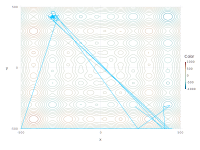

Particle([-300.543, 420.238], -718.963040700535, 0)


In [11]:
x = [214.0, -317.0]
pathx = [x[1]]
pathy = [x[2]]
par = Particle(x, s.f(x), 0)
for i= 1:100
    b = s.lbound + rand(s.dim).*(s.ubound - s.lbound)
    par = diffusion(par, p, s, convert(UInt64, i), Particle(b, s.f(b), 0))
    println("$par")
    push!(pathx, par.x[1])
    push!(pathy, par.x[2])
    display(plot(layer(x=pathx, y=pathy, Geom.path),
                 layer(x=s.lbound[1]:10:s.ubound[1], y=s.lbound[2]:10:s.ubound[2], z=(x,y) -> s.f([x,y]), Geom.contour)))
    #sleep(0.01)
    IJulia.clear_output(true)
    push!(pathx, par.x[1])
    push!(pathy, par.x[2])
end

### Actualización
Ordenamos los puntos por su evaluación y les asignamos una probabilidad:  
$Pa_i = \frac{rank(P_i)}{N}$  
Siendo $N$ el número de puntos.

Dos procesos de actualización:  
1. Con probabilidad $Pa_i$:  
   $P'_i(j) = P_r(j) - \epsilon (P_t(j) - P_i(j))$  
   Con $\epsilon \sim U(0, 1)$
   
2. Con probabilidad $Pa_i$:  
   $P''_i = P'_i - \bar{\epsilon} (P'_t - BP) \mid \epsilon' \leq 0.5$  
   $P''_i = P'_i + \bar{\epsilon} (P'_t - P'_r) \mid \epsilon' \gt 0.5$  
   Con $\epsilon' \sim U(0, 1)$, $\bar{\epsilon} \sim N(0, 1)$
   
$P''_i$ sustituye a $P_i$ si es mejor

In [8]:
function stochastic_fractal_search(sp::SearchParams, s::SearchSpace)
    # Población inicial de partículas
    points = [s.lbound + rand(s.dim).*(s.ubound - s.lbound) for i=1:sp.initial_population]
    particles = [Particle(p, s.f(p), 0) for p in points]
    
    # Mejor partícula de la población inicial
    best = minimum(particles)
    
    for g = 1:sp.max_generations
        # Proceso de difusión
        particles = sort(diffusion.(particles, sp, s, g, best))
        new_best = particles[1]
        
        # Primer proceso de actualización
        size = length(particles)
        Pa = [(size - i + 1) / size for i=1:size] 
        randvec1 = randperm(size)
        randvec2 = randperm(size)
        for i = 1:size
            p = copy(particles[i])
            for j = 1:s.dim
                if rand() > Pa[i]
                    p.x[j] = particles[randvec1[i]].x[j] -
                                       rand()*(particles[randvec2[i]].x[j] - p.x[j])
                end
            end
            p.x = check_bounds(p.x, s.lbound, s.ubound)
            p.f = s.f(p.x)
            if p.f <= particles[i].f
                particles[i] = p
            end
        end
        
        particles = sort(particles)
        new_best = particles[1]
        if (new_best.f < best.f)
            best = copy(new_best)
        end
        
        # Segundo proceso de actualización
        for i = 1:size
            if rand() > Pa[i]
                t = ceil(Int, rand()*size)
                r = ceil(Int, rand()*size)
                while t == r
                    r = ceil(Int, rand()*size)
                end
                
                p = copy(particles[i])
                if rand() < 0.5
                    p.x = check_bounds(p.x - rand() * (particles[t].x - best.x), s.lbound, s.ubound)
                    p.f = s.f(p.x)
                else
                    p.x = check_bounds(p.x + rand() * (particles[t].x - particles[r].x), s.lbound, s.ubound)
                    p.f = s.f(p.x)
                end
                
                if p.f < particles[i].f
                    particles[i] = p
                end
            end
        end
        
        new_best = minimum(particles)
        if (new_best.f < best.f)
            best = copy(new_best)
        end
        
        println("Iteration $g")
        println("Best result: $best")
    end
end

stochastic_fractal_search (generic function with 1 method)

In [12]:
stochastic_fractal_search(p, s)

Iteration 1
Best result: Particle([413.079, 467.266], -582.2447807231912, 0)
Iteration 2
Best result: Particle([425.713, 460.164], -652.6181216783652, 0)
Iteration 3
Best result: Particle([425.713, 460.162], -652.6317750838314, 0)
Iteration 4
Best result: Particle([408.41, 443.023], -757.8945708572644, 0)
Iteration 5
Best result: Particle([399.319, 425.088], -778.5659519099268, 0)
Iteration 6
Best result: Particle([404.928, 428.313], -799.3124002636551, 0)
Iteration 7
Best result: Particle([404.929, 428.311], -799.3196990469822, 0)
Iteration 8
Best result: Particle([404.93, 428.31], -799.3278074334709, 0)
Iteration 9
Best result: Particle([404.931, 424.556], -804.508512969094, 0)
Iteration 10
Best result: Particle([404.934, 424.557], -804.516830272321, 0)
Iteration 11
Best result: Particle([405.797, 427.151], -804.6043942219101, 0)
Iteration 12
Best result: Particle([405.028, 422.541], -806.1956614144947, 0)
Iteration 13
Best result: Particle([413.345, 423.197], -830.0475932980061, 0)


# Mejoras

- Simplificar el algoritmo
- Probar con otros caminos aleatorios
- Añadir una búsqueda local
- Adaptar los parámetros
    - Proporcionar los saltos al tamaño del espacio de búsqueda
    - Ajustar la difusión máxima
- Volver a una estructura fractal para añadir diversidad